In [1]:
!nvidia-smi

Mon Jul 17 13:38:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   24C    P0    54W / 400W |      0MiB / 40960MiB |      0%   E. Process |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from rosemary import jpt_setup; jpt_setup()

from llm.submit import multiline_to_singleline, submit_job_ccc, get_run_statistics
import pandas as pd
import json

/dccstor/mit_fm/wpq/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [3]:

cols = ['model', 'size', 'mixed-precision', 'deepspeed', 
        'gpu mem usage (GB)', 'per-epoch time (hr)', 'per-iter time (s)']

# 55k data points, batch_size=128
data_oasst1 = [
    ('gpt2', 0.124, 'bf16', 'no', 10, None, None),
    ('gpt2-Large', 0.774, 'bf16', 'no', 36, 2.5, 11),
    # incorporate deep speed is costly!
    ('gpt2-Large', 0.774, 'bf16', 'stage 3 no offloading', 40, 6, 25),
    # 1 a100_40g: without offloading OOM on `.backward()`, runs fine with offloading.
    ('gpt2-xl', 1.5, 'bf16', 'stage 3 with offloading', 40, 13, 55),
    # 4 v100_32g: without offloading.
]

df_oasst1 = pd.DataFrame(data_oasst1, columns=cols)

cols = ['model', 'size', 'mixed-precision', 'deepspeed', 
        'gpu mem (GB)', 'cpu mem (GB)', 'per-epoch time (hr)', 'per-iter time (s)']
data = [
    ('gpt2-Large', 0.774, 'bf16', 'no', 36, 7, 9.5, 9),
]

print('instruction tune human-mix on 1 a100_40g:')
df = pd.DataFrame(data, columns=cols)
df

instruction tune human-mix on 1 a100_40g:


,model,size,mixed-precision,deepspeed,gpu mem (GB),cpu mem (GB),per-epoch time (hr),per-iter time (s)
0,gpt2-Large,0.774,bf16,no,36,7,9.5,9


# Finetuning with openinstruct/finetune.py


In [4]:
shell_scripts_template = """
export OPENAI_API_KEY=$(cat ~/.openai_api_key)
export HF_HOME="/dccstor/mit_fm/wpq/hf_cache/"

source /dccstor/mit_fm/miniconda/bin/activate open-instruct
cd /dccstor/mit_fm/wpq/github/mitibm2023/external/open-instruct/

echo "Running on $(hostname)"
echo "======"
echo {cmd}
echo "======"

{cmd}

[ ! -f "{log_dir}/${{LSB_JOBID}}*.out" ] || mv "{log_dir}/${{LSB_JOBID}}*.out" "{save_dir}"
"""



In [149]:
job_name = 'ft'
test_run = 1
test_run = bool(test_run)

queue = 'x86_12h' # 'x86_12h'
num_cpus = 20
num_gpus = 1
cpu_mem = 32
require = 'a100_80gb'

# model_name_or_path = 'mosaicml/mpt-7b'; max_seq_length = 2048
# model_name_or_path = 'gpt2'; max_seq_length = 1024
# model_name_or_path = 'gpt2-Large'; max_seq_length = 1024
# model_name_or_path = 'gpt2-xl'; max_seq_length = 1024
model_name_or_path = 'huggyllama/llama-7b'; max_seq_length = 2048


train_file = 'data/processed/oasst1/oasst1_data.jsonl'; train_file_short = 'oasst1'
train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; train_file_short = 'human_mix'
# train_file = 'data/processed/flanv2_cot_oasst1_dolly_shuffled.jsonl'; train_file_short = 'human_mix_shuffled'

output_dir = f"results/{model_name_or_path.replace('/', ':')}_{train_file_short}"
if test_run:
    output_dir = 'jpt_' + output_dir

use_deepspeed = False
# deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate_setauto.conf'
# deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate.conf'
deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate_setauto.conf'

use_lora = True
lora_rank = 4
lora_alpha = lora_rank
lora_dropout = 0.05

batch_size_per_gpu = 1
total_batch_size = 128
mixed_precision = 'bf16' # 'bf16', 'fp16'
checkpointing_steps = None # every n steps, where n='1' or every 'epoch'

gradient_acc_steps = int(total_batch_size/num_gpus/batch_size_per_gpu)

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{batch_size_per_gpu} batch size per GPU, "
      f"{gradient_acc_steps} gradient accumulation steps.")

# do use fast tokenizer since mpt-7b does not have a fast tokenizer counter-part
#     --use_slow_tokenizer \
# do not use flash attention, since having problem installing flash-attn with cuda 12.1
#     --use_flash_attn \

cmd = f"""
{'!cd .. && ' if test_run else ''}accelerate launch \
    --mixed_precision {mixed_precision} \
    --num_machines 1 \
    --num_processes {num_gpus} \
    {'--use_deepspeed' if use_deepspeed else ''}
    {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''}
    open_instruct/finetune.py \
    --model_name_or_path {model_name_or_path} \
    --tokenizer_name {model_name_or_path} \
    --train_file {train_file} \
    --max_seq_length {max_seq_length} \
    {'--use_lora' if use_lora else ''}
    --lora_rank {lora_rank} \
    --lora_alpha {lora_alpha} \
    --lora_dropout {lora_dropout} \
    --preprocessing_num_workers 16 \
    --per_device_train_batch_size {batch_size_per_gpu} \
    --gradient_accumulation_steps {gradient_acc_steps} \
    --learning_rate 2e-5 \
    --lr_scheduler_type linear \
    --warmup_ratio 0.03 \
    --weight_decay 0. \
    --num_train_epochs 2 \
    --output_dir {output_dir} \
    --with_tracking \
    --report_to tensorboard \
    {'--checkpointing_steps '+str(checkpointing_steps) if checkpointing_steps else ''}
    --logging_steps 1
"""

# things to test to see its effects on (1) eval perf (2) runtime.
#
# - int8
# - mixed_precision bf16 or no
# - with/without LoRA
# - LoRA's rank/alpha (alpha typically set to 2*rank)
# - batch size
# - micro-batch size (largest without running out of memory)


cmd = multiline_to_singleline(cmd)
if test_run:
    print()
    print(cmd)

shell_scripts = shell_scripts_template.format(
    cmd=cmd,
    log_dir=os.getcwd(),
    save_dir=output_dir)
out = submit_job_ccc(
    shell_scripts, 
    job_name=job_name, 
    queue=queue,
    num_cpus=num_cpus,
    cpu_mem=cpu_mem,
    require=require,
    num_gpus=num_gpus,
    test_run=test_run,
)
if not test_run:
    print(out)

Training huggyllama/llama-7b using 2 GPUs, 2 batch size per GPU, 32 gradient accumulation steps.

!cd .. && accelerate launch --mixed_precision bf16 --num_machines 1 --num_processes 2 open_instruct/finetune.py --model_name_or_path huggyllama/llama-7b --tokenizer_name huggyllama/llama-7b --train_file data/processed/flanv2_cot_oasst1_dolly.jsonl --max_seq_length 2048 --lora_rank 4 --lora_alpha 4 --lora_dropout 0.05 --preprocessing_num_workers 16 --per_device_train_batch_size 2 --gradient_accumulation_steps 32 --learning_rate 2e-5 --lr_scheduler_type linear --warmup_ratio 0.03 --weight_decay 0. --num_train_epochs 2 --output_dir jpt_results/huggyllama:llama-7b_human_mix --with_tracking --report_to tensorboard --logging_steps 1


In [15]:
# llama7b+lora, micro-bsz=1, bsz=128, 
#     66gb gpu mem, in it 28gb for torch tensor. so fit on 1 a100_80gb

#   1%|▏         | 57/4222 [22:24<25:53:47, 22.38s/it]07/11/2023 23:13:55 - INFO - 
# __main__ -   Step: 57, LR: 9.047619047619049e-06, Loss: 2.2924644947052
# 


!cd .. && accelerate launch --mixed_precision bf16 --num_machines 1 --num_processes 1 open_instruct/finetune.py --model_name_or_path huggyllama/llama-7b --tokenizer_name huggyllama/llama-7b --train_file data/processed/flanv2_cot_oasst1_dolly.jsonl --max_seq_length 2048 --use_lora --lora_rank 4 --lora_alpha 4 --lora_dropout 0.05 --preprocessing_num_workers 16 --per_device_train_batch_size 1 --gradient_accumulation_steps 128 --learning_rate 2e-5 --lr_scheduler_type linear --warmup_ratio 0.03 --weight_decay 0. --num_train_epochs 2 --output_dir results/huggyllama:llama-7b_human_mixjpt_results/huggyllama:llama-7b_human_mix --with_tracking --report_to tensorboard --logging_steps 1





The following values were not passed to `accelerate launch` and had defaults used instead:
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
/dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /dccstor/mit_fm/miniconda/envs/open-instruct did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/opt/ibm/lsfsuite/ext/ppm/10.2/linux2.6-glibc2.3-x86_64/lib')}
  warn(msg)

loading file tokenizer.model from cache at /dccstor/mit_fm/wpq/hf_cache/hub/models--huggyllama--llama-7b/snapshots/8416d3fefb0cb3ff5775a7b13c1692d10ff1aa16/tokenizer.model
loading file tokenizer.json from cache at /dccstor/mit_fm/wpq/hf_cache/hub/models--huggyllama--llama-7b/snapshots/8416d3fefb0cb3ff5775a7b13c1692d10ff1aa16/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /dccstor/mit_fm/wpq/hf_cache/hub/models--huggyllama--llama-7b/snapshots/8416d3fefb0cb3ff5775a7b13c1692d10ff1aa16/special_tokens_map.json
loading file tokenizer_config.json from cache at /dccstor/mit_fm/wpq/hf_cache/hub/models--huggyllama--llama-7b/snapshots/8416d3fefb0cb3ff5775a7b13c1692d10ff1aa16/tokenizer_config.json
loading weights file model.safetensors from cache at /dccstor/mit_fm/wpq/hf_cache/hub/models--huggyllama--llama-7b/snapshots/8416d3fefb0cb3ff5775a7b13c1692d10ff1aa16/model.safetensors.index.json
Instantiating LlamaForCausalLM model unde

07/12/2023 13:01:07 - INFO - __main__ - ***** Running training *****
07/12/2023 13:01:07 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) =  Num examples = 270152
07/12/2023 13:01:07 - INFO - __main__ -   Num Epochs = 2
07/12/2023 13:01:07 - INFO - __main__ -   Instantaneous batch size per device = 1
07/12/2023 13:01:07 - INFO - __main__ -  128
07/12/2023 13:01:07 - INFO - __main__ -   Gradient Accumulation steps = 128
07/12/2023 13:01:07 - INFO - __main__ -   Total optimization steps = 4222
  0%|                                                  | 0/4222 [00:00<?, ?it/s]before train loop:
GPU memory occupied: 14747 MB.
torch.cuda.memory_allocated():  13552361472
model.device: cuda:0
model.dtype: torch.bfloat16
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          

  1%|▎                                     | 29/4222 [11:00<25:30:06, 21.90s/it]07/12/2023 13:12:08 - INFO - __main__ -   Step: 29, LR: 4.603174603174604e-06, Loss: 2.1846425533294678
GPU memory occupied: 65457 MB.
torch.cuda.memory_allocated():  13609034752
  1%|▎                                     | 30/4222 [11:24<26:26:01, 22.70s/it]07/12/2023 13:12:32 - INFO - __main__ -   Step: 30, LR: 4.761904761904762e-06, Loss: 2.024883270263672
GPU memory occupied: 65457 MB.
torch.cuda.memory_allocated():  13641553920
  1%|▎                                     | 31/4222 [11:49<27:12:57, 23.38s/it]07/12/2023 13:12:57 - INFO - __main__ -   Step: 31, LR: 4.920634920634921e-06, Loss: 2.1247711181640625
GPU memory occupied: 65457 MB.
torch.cuda.memory_allocated():  13728229888
  1%|▎                                     | 32/4222 [12:10<26:22:46, 22.67s/it]07/12/2023 13:13:18 - INFO - __main__ -   Step: 32, LR: 5.07936507936508e-06, Loss: 2.2556421756744385
GPU memory occupied: 65457 MB.
torch.cuda

  1%|▌                                     | 61/4222 [23:21<26:16:36, 22.73s/it]07/12/2023 13:24:29 - INFO - __main__ -   Step: 61, LR: 9.682539682539683e-06, Loss: 1.951716661453247
GPU memory occupied: 65969 MB.
torch.cuda.memory_allocated():  13657301504



KeyboardInterrupt



# Finetuning with openinstruct/finetune_trainer.py


In [ ]:
# runtime:
# shared: humanmix, max_sequence_length=2048.
# just a single process if num_gpus=1 otherwise use python fsdp with gradient-checkpointing.
#
# llama7b, micro-bsz=2, grad-ckpt, 2xa100_80gb: 27s/it, 32hrs
# 
# llama7b+lora(r=4),   micro-bsz=1, no-grad-ckpt,a100_80gb: 27s/it, 32hrs, 66gb gpu mem
# llama7b+lora(r=16),  micro-bsz=1, no-grad-ckpt,a100_80gb: 24s/it, 28hrs, 67gb gpu mem
# llama7b+lora(r=256), micro-bsz=1, no-grad-ckpt,a100_80gb: 24s/it, 28hrs, 70gb gpu mem
#
# llama7b+lora(r=4),   micro-bsz=1,  grad-ckpt,  a100_80gb: 32s/it, 38hrs
# llama7b+lora(r=4),   micro-bsz=2,  grad-ckpt,  a100_80gb: 32s/it, 38hrs (+20% runtime with grad-ckpt)
# llama7b+lora(r=4),   micro-bsz=16, grad-ckpt,  a100_80gb: 68s/it, 80hrs, 75gb gpu mem
# llama7b+lora(r=128), micro-bsz=16, grad-ckpt,  a100_80gb: 70s/it, 82hrs
# 
# take-aways
# - larger batch should speed up training. however, it also implies that the batch 
#   will be padded to longer sequence length, due to chat data, thereby increasing
#   compute required to process a batch. Therefore, micro-bsz=1 seems to be ok.
#


In [7]:
job_name = 'ft-trainer'
test_run = 1
test_run = bool(test_run)
# specify `job_duration` to chain jobs for >12hr jobs.
job_duration = None
shell_scripts_modification_fn = lambda x: x.replace('--overwrite_output_dir ', '')

queue = 'x86_12h' # 'x86_12h'
num_cpus = 32
cpu_mem = 64
num_gpus = 2; require = 'a100_80gb'

overwrite_output_dir = False
save_strategy = 'steps'
save_steps = 100

model_name_or_path = 'huggyllama/llama-7b'; max_seq_length = 2048
# model_name_or_path = 'gpt2'; max_seq_length = 1024
train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; abbr_train_file = 'humanmix'

num_train_epochs = 2
batch_size_per_gpu = 1
total_batch_size = 128
mixed_precision = 'bf16' # 'bf16', 'fp16'
gradient_acc_steps = int(total_batch_size/num_gpus/batch_size_per_gpu)


fsdp = False if num_gpus == 1 else "full_shard auto_wrap"
if 'gpt2' in model_name_or_path: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in model_name_or_path: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')

use_lora = False
lora_rank = 128 # test {8, 16, 32, 128} # just [128, 8] for now.
lora_alpha = lora_rank
lora_dropout = 0.05
gradient_checkpointing = True

load_in_8bit = False

abbr_model_name = model_name_or_path.replace('/', ':')
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'
output_dirname = f"{abbr_model_name}_{abbr_train_file}"
if test_run:
    output_dirname = 'jpt_'+output_dirname
output_dir = os.path.join('results', output_dirname)


print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{batch_size_per_gpu} batch size per GPU, "
      f"{gradient_acc_steps} gradient accumulation steps.")

exe = 'python' if num_gpus == 1 else f"torchrun --nproc_per_node={num_gpus} --master_port=10001"

cmd = f"""
{'!cd .. && ' if test_run else ''}{exe}
    open_instruct/finetune_trainer.py \
    --model_name_or_path {model_name_or_path} \
    --tokenizer_name {model_name_or_path} \
    {'--load_in_8bit' if load_in_8bit else ''} \
    --use_fast_tokenizer True \
    --train_file {train_file} \
    --max_seq_length {max_seq_length} \
    {'--use_lora' if use_lora else ''}
    {'--lora_rank '+str(lora_rank) if use_lora else ''}
    {'--lora_alpha '+str(lora_alpha) if use_lora else ''}
    {'--lora_dropout '+str(lora_dropout) if use_lora else ''}
    --do_train \
    --preprocessing_num_workers 16 \
    --per_device_train_batch_size {batch_size_per_gpu} \
    --gradient_accumulation_steps {gradient_acc_steps} \
    --learning_rate 2e-5 \
    --lr_scheduler_type linear \
    --warmup_ratio 0.03 \
    --weight_decay 0. \
    --evaluation_strategy "no" \
    --logging_steps 1 \
    --save_strategy {save_strategy} \
    --save_steps {save_steps} \
    --save_total_limit 1 \
    --num_train_epochs {num_train_epochs} \
    {'--fsdp "'+fsdp+'"' if fsdp else ''}
    {'--fsdp_transformer_layer_cls_to_wrap "'+fsdp_transformer_layer_cls_to_wrap+'"' 
        if fsdp else ''}
    {'--gradient_checkpointing' if gradient_checkpointing  else ''}
    --bf16 True \
    --tf32 True \
    --report_to tensorboard \
    --torch_dtype bfloat16 \
    --dataloader_num_workers 8 \
    {'--overwrite_output_dir' if overwrite_output_dir else ''} \
    --output_dir "{output_dir}"
"""


cmd = multiline_to_singleline(cmd)
if test_run:
    print()
    print(cmd)

shell_scripts = shell_scripts_template.format(
    cmd=cmd,
    log_dir=os.getcwd(),
    save_dir=output_dir)
out = submit_job_ccc(
    shell_scripts, 
    job_name=job_name, 
    queue=queue,
    num_cpus=num_cpus,
    cpu_mem=cpu_mem,
    require=require,
    num_gpus=num_gpus,
    test_run=test_run,
    job_duration=job_duration,
    shell_scripts_modification_fn=shell_scripts_modification_fn,
)
if not test_run:
    print(out)

Training huggyllama/llama-7b using 2 GPUs, 1 batch size per GPU, 64 gradient accumulation steps.
[{'jbsub_cmd': 'jbsub -queue x86_12h -name ft-trainer -mem 64g -cores 1x32+2 -require a100_80gb -out /dccstor/mit_fm/wpq/github/mitibm2023/external/open-instruct/scripts/%J.out bash -c \'export OPENAI_API_KEY=$(cat ~/.openai_api_key); export HF_HOME="/dccstor/mit_fm/wpq/hf_cache/"; source /dccstor/mit_fm/miniconda/bin/activate open-instruct; cd /dccstor/mit_fm/wpq/github/mitibm2023/external/open-instruct/; echo "Running on $(hostname)"; echo "======"; echo torchrun --nproc_per_node=2 --master_port=10001 open_instruct/finetune_trainer.py --model_name_or_path huggyllama/llama-7b --tokenizer_name huggyllama/llama-7b --use_fast_tokenizer True --train_file data/processed/flanv2_cot_oasst1_dolly.jsonl --max_seq_length 2048 --do_train --preprocessing_num_workers 16 --per_device_train_batch_size 1 --gradient_accumulation_steps 64 --learning_rate 2e-5 --lr_scheduler_type linear --warmup_ratio 0.03 -

In [33]:

!cd .. && python open_instruct/finetune_trainer.py --model_name_or_path huggyllama/llama-7b --tokenizer_name huggyllama/llama-7b --use_fast_tokenizer True --train_file data/processed/flanv2_cot_oasst1_dolly.jsonl --max_seq_length 2048 --use_lora --lora_rank 256 --lora_alpha 256 --lora_dropout 0.05 --do_train --preprocessing_num_workers 16 --per_device_train_batch_size 1 --gradient_accumulation_steps 128 --learning_rate 2e-5 --lr_scheduler_type linear --warmup_ratio 0.03 --weight_decay 0. --evaluation_strategy "no" --logging_steps 1 --save_strategy steps --save_steps 200 --save_total_limit 1 --num_train_epochs 2 --bf16 True --tf32 True --overwrite_output_dir --report_to tensorboard --torch_dtype bfloat16 --dataloader_num_workers 8 --output_dir "results/jpt_huggyllama:llama-7b+lora(r=256,a=256)_humanmix"



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
/dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /dccstor/mit_fm/miniconda/envs/open-instruct did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/opt/ibm/lsfsuite/ext/ppm/10.2/linux2.6-glibc2.3-x86_64/lib')}
  warn(msg)
/dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /opt/ibm/lsfsuite/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/opt/ibm/lsfsuite/ext/ppm/10.2/linux2.6-glibc2.3-x86_64/lib did

07/14/2023 14:10:13 - INFO - datasets.builder - Using custom data configuration default-247ebf1b4910b0d3
07/14/2023 14:10:13 - INFO - datasets.info - Loading Dataset Infos from /dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/datasets/packaged_modules/json
07/14/2023 14:10:13 - INFO - datasets.builder - Overwrite dataset info from restored data version if exists.
07/14/2023 14:10:13 - INFO - datasets.info - Loading Dataset info from /dccstor/mit_fm/wpq/hf_cache/datasets/json/default-247ebf1b4910b0d3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96
07/14/2023 14:10:13 - WARNING - datasets.builder - Found cached dataset json (/dccstor/mit_fm/wpq/hf_cache/datasets/json/default-247ebf1b4910b0d3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
07/14/2023 14:10:13 - INFO - datasets.info - Loading Dataset info from /dccstor/mit_fm/wpq/hf_cache/datasets/json/default-247ebf1b4910b0d3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd4

07/14/2023 14:13:52 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /dccstor/mit_fm/wpq/hf_cache/datasets/json/default-247ebf1b4910b0d3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-fc0eb8d201835f20_*_of_00016.arrow
07/14/2023 14:13:52 - INFO - datasets.arrow_dataset - Concatenating 16 shards
[INFO|trainer.py:776] 2023-07-14 14:14:10,575 >> The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: dataset, messages, id. If dataset, messages, id are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
/dccstor/mit_fm/miniconda/envs/open-instruct/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  w


KeyboardInterrupt



# eval



In [8]:
shell_scripts_template = """
export OPENAI_API_KEY=$(cat ~/.openai_api_key)
export HF_HOME="/dccstor/mit_fm/wpq/hf_cache/"

source /dccstor/mit_fm/miniconda/bin/activate open-instruct
cd /dccstor/mit_fm/wpq/github/mitibm2023/external/open-instruct/

echo "Running on $(hostname)"
echo "======"
echo {cmd}
echo "======"
g
{cmd}

[ ! -f "{log_dir}/${{LSB_JOBID}}.out" ] || mv "{log_dir}/${{LSB_JOBID}}.out" "{save_dir}"
"""

In [5]:
models = ['results/huggyllama:llama-7b_human_mix-trainer_savebystep/']
models = [glob.glob(os.path.join(x, 'checkpoint*')) for x in models]
models = [x for l in models for x in l]
models

NameError: name 'glob' is not defined

In [24]:
# mmlu, 0-shot
# gsm, 8-shot
# bbh, 0-shot
# bbh, 3-shot
# 

False

In [143]:
# task_name = 'bbh_s=0'
# task_name = 'bbh_s=3'
# task_name = 'gsm'
# task_name = 'mmlu'
task_name = 'humaneval'
job_name = f'eval.{task_name}'

test_run = 1
test_run = bool(test_run)

batch_size = 10
if task_name == 'gsm':
    queue = 'x86_6h'
if task_name == 'bbh_s=0':
    queue = 'x86_1h'
if task_name == 'bbh_s=3':
    queue = 'x86_6h'
    batch_size = 5 # for longer prompts.
if task_name == 'mmlu':
    queue = 'x86_1h'
    batch_size = 10
if task_name == 'humaneval':
    queue = 'x86_1h' # pass@1: 10min, pass@10: 100min
    batch_size = 10
    
num_cpus = 10
cpu_mem = 32 # mem usage quite small for llama7b+lora on bbh

use_chat_format = False
load_in_8bit = False

models = []
# models += ['t5-small', 't5-base', 't5-large', 't5-3b', 't5-11b']
# models += ['t5-11b']
# models += ['google/flan-t5-small', 'google/flan-t5-base', 'google/flan-t5-large', 'google/flan-t5-xl', 'google/flan-t5-xxl']
# models += ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
models += ['huggyllama/llama-7b'] # , 'mosaicml/mpt-7b'
models = [os.path.join('results/baselines', x) for x in models]


# models += ['results/huggyllama:llama-7b_human_mix-trainer_savebystep/']
# models = [glob.glob(os.path.join(x, 'checkpoint*')) for x in models]
# models = [x for l in models for x in l]
# models += ['results/huggyllama:llama-7b_human_mix-trainer_savebystep/checkpoint-1400']

info = {}  
cmds = []
for model_name_or_path in models:
    run_id = model_name_or_path
    save_dir = f'{model_name_or_path}/eval/{task_name}'
    if use_chat_format:
        save_dir += '_chatfmt'
    
    if task_name == 'mmlu':
        cmd = f"""
        python -m eval.mmlu.run_eval \
            --data_dir data/eval/mmlu \
            --save_dir {model_name_or_path}/eval/mmlu/ \
            --model_name_or_path {model_name_or_path} \
            --eval_batch_size {batch_size} \
            --ntrain 0 \
            {'--use_chat_format' if use_chat_format else ''}
        """
    if task_name == 'gsm':
        cmd = f"""
        python -m eval.gsm.run_eval \
            --data_dir data/eval/gsm/ \
            --model_name_or_path {model_name_or_path} \
            --save_dir {save_dir} \
            --eval_batch_size {batch_size} \
            --n_shot 8 \
            {'--use_chat_format' if use_chat_format else ''}
        """
    if task_name.startswith('bbh'):
        cmd = f"""
        python -m eval.bbh.run_eval \
            --data_dir data/eval/bbh/ \
            --model_name_or_path {model_name_or_path} \
            --save_dir {save_dir} \
            --eval_batch_size {batch_size} \
            {'--no_cot' if 's=0' in task_name else ''}
            {'--use_chat_format' if use_chat_format else ''}
        """
    if task_name.startswith('humaneval'):
        cmd = f"""
        python -m eval.codex_humaneval.run_eval \
            --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
            --model_name_or_path {model_name_or_path} \
            --save_dir {save_dir} \
            --eval_batch_size {batch_size} \
            --eval_pass_at_ks 1 \
            --unbiased_sampling_size_n 1 \
            --temperature 0.1 \
            {'--use_chat_format' if use_chat_format else ''}
            {'--load_in_8bit' if load_in_8bit else ''}
        """
        
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    print(cmd)
    
    # submit
    shell_scripts = shell_scripts_template.format(
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=save_dir)
    out = submit_job_ccc(
        shell_scripts, 
        job_name=job_name, 
        queue=queue,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=1,
        test_run=test_run,
    )
#     if test_run: print(out['jbsub_cmd'])
    
    

python -m eval.codex_humaneval.run_eval --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz --model_name_or_path results/baselines/huggyllama/llama-7b --save_dir results/baselines/huggyllama/llama-7b/eval/humaneval --eval_batch_size 10 --eval_pass_at_ks 1 --unbiased_sampling_size_n 1 --temperature 0.1


In [149]:
class EvalResults:
    
    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.eval_dir = os.path.join(self.save_dir, 'eval')
        
    def get_result_df(self):

        task_names = os.listdir(self.eval_dir)

        dfs = []
        for task_name in task_names:
            task_save_dir = os.path.join(self.eval_dir, task_name)
            metrics_file = os.path.join(task_save_dir, 'metrics.json')
            if not os.path.exists(metrics_file):
                continue
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)

            if 'mmlu' in task_name:
                for k, v in metrics['subcat_acc'].items():
                    metrics[k] = v
                del metrics['subcat_acc']
                for k, v in metrics['cat_acc'].items():
                    metrics[k] = v
                del metrics['cat_acc']

            index = [(task_name, k) for k in metrics.keys()]
            multi_columns = pd.MultiIndex.from_tuples(index, names=['task_name', 'metrics'])
            data = list(metrics.values())

            df = pd.DataFrame([data], columns=multi_columns)
            dfs.append(df)

        df = pd.concat(dfs, axis=1)
        cols = [
            ('mmlu', 'average_acc'),
            ('gsm', 'exact_match'),
            ('bbh_s=0', 'average_exact_match'),
            ('bbh_s=3', 'average_exact_match'),
            ('humaneval', 'pass@1')
        ]
        cols = [col for col in cols if col in df]
        print(task_names)
        df = df[cols]
        df.insert(0, ('model', ''), [self.save_dir])
        return df


save_dirs = [
    '../results/baselines/huggyllama/llama-7b/',
    '../results/huggyllama:llama-7b_human_mix-trainer_savebystep/checkpoint-1400',
]

dfs = []
for save_dir in save_dirs:
    r = EvalResults(save_dir)
    df = r.get_result_df()
    dfs.append(df)

pd.set_option('display.max_colwidth', None)

df = pd.concat(dfs, axis=0)
display(df)


['bbh_s=0', 'bbh_s=3', 'humaneval', 'gsm', 'mmlu']
['bbh_s=0', 'bbh_s=0_chatfmt', 'bbh_s=3', 'gsm_chatfmt', 'gsm', 'mmlu']


task_name,model,mmlu,gsm,bbh_s=0,bbh_s=3,humaneval
metrics,,average_acc,exact_match,average_exact_match,average_exact_match,pass@1
0,../results/baselines/huggyllama/llama-7b/,0.318687,0.109932,0.316671,0.334654,0.140244
0,../results/huggyllama:llama-7b_human_mix-trainer_savebystep/checkpoint-1400,0.333001,0.100834,0.332591,0.343629,NaN


In [35]:
import glob

models = []
models += ['t5-small', 't5-base', 't5-large', 't5-3b', 't5-11b']
models += ['huggyllama/llama-7b']
save_dirs = [f'../results/baselines/{x}/eval/gsm/' for x in models]

data = []
for model, save_dir in zip(models, save_dirs):
    logfile_path = glob.glob(os.path.join(save_dir, '*.out'))[0]
    out = get_run_statistics(logfile_path)
    with open(os.path.join(save_dir, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    data.append((model, out['cpu_time']/60/60, out['avg_mem'], out['max_mem'], metrics['exact_match']))
    

import pandas as pd
columns = ['name', 'cpu_time (hr)', 'avg_mem', 'max_mem', 'exact_match']
df = pd.DataFrame(data, columns=columns)
df

,name,cpu_time (hr),avg_mem,max_mem,exact_match
0,t5-small,0.038869,0.491738,0.597656,0.014405
1,t5-base,0.071833,0.729512,0.787109,0.018196
2,t5-large,0.021314,0.957783,1.317383,0.000000
3,t5-3b,0.208883,6.689150,11.693359,0.013647
4,t5-11b,0.458394,0.872705,33.018555,0.009098
5,huggyllama/llama-7b,0.790400,0.639141,0.710938,0.109932


In [67]:
datasets = [
    # human-authored
    'SuperNI',
    'CoT',
    'Flan V2',
    'Dolly',
    'Open Assistant 1',
    # gpt-generated
    'Self-instruct',
    'Unnatural Instructions',
    'Alpaca',
    'Code-Alpaca',
    'GPT4-Alpaca',
    'Baize',
    'ShareGPT',
]
N = len(datasets)

def encode_input(dataset):
    if dataset == 'LLaMa-13B':
        return [0]*N
    if dataset == 'Human data mix':
        # FLAN V2, CoT, Dolly, and Open Assistant 1
        return [0,1,1,1,1,0,0,0,0,0,0,0]
    if dataset == 'Human+GPT data mix.':
        # FLAN V2, CoT, Dolly, and Open Assistant 1, GPT4-Alpaca, Code-Alpaca, and ShareGPT.
        return [0,1,1,1,1,0,0,0,1,1,0,1]
    x = [0]*N
    i = datasets.index(dataset)
    x[i] = 1
    return x

import numpy as np
X = [encode_input(x[0]) for x in data]
X = np.array(X)
X


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]])

In [49]:
import pandas as pd

data = [
    ['LLaMa-13B', 42.5, 14.0, 36.9, 47.4, 26.6, None, None],
    ['SuperNI', 49.8, 4.0, 2.8, 51.4, 13.1, 5.0, 21.0],
    ['CoT', 44.5, 39.5, 39.0, 52.2, 23.3, 4.7, 33.9],
    ['Flan V2', 50.7, 21.0, 39.2, 47.5, 16.2, 5.3, 30.0],
    ['Dolly', 45.3, 17.0, 26.0, 46.8, 31.4, 18.3, 30.8],
    ['Open Assistant 1', 43.1, 16.0, 38.5, 38.3, 31.8, 55.2, 37.1],
    ['Self-instruct', 30.3, 9.0, 29.6, 40.4, 13.4, 7.3, 21.7],
    ['Unnatural Instructions', 46.2, 7.5, 32.8, 39.3, 24.8, 10.8, 26.9],
    ['Alpaca', 45.1, 8.0, 34.5, 32.8, 27.6, 33.2, 30.2],
    ['Code-Alpaca', 42.6, 12.0, 36.6, 41.3, 34.5, 21.3, 31.4],
    ['GPT4-Alpaca', 47.0, 14.0, 38.3, 24.4, 32.5, 63.6, 36.6],
    ['Baize', 43.5, 8.5, 36.7, 33.9, 27.3, 33.9, 30.6],
    ['ShareGPT', 49.2, 16.0, 40.1, 30.1, 31.6, 69.1, 39.3],
    ['Human data mix', 50.4, 36.5, 39.4, 49.8, 23.7, 38.5, 39.7],
    ['Human+GPT data mix.', 49.2, 36.5, 42.8, 46.1, 35.0, 57.2, 44.5]
]

columns = [
    'Model', 'MMLU', 'GSM', 'BBH', 'TydiQA', 'Codex-Eval', 'AlpacaFarm',
    'Average'
]

df = pd.DataFrame(data, columns=columns)

tasks = ['MMLU', 'GSM', 'BBH', 'TydiQA', 'Codex-Eval']
base_model_perf = df.iloc[0][tasks]
df[tasks] = df[tasks].subtract(base_model_perf)

df

,Model,MMLU,GSM,BBH,TydiQA,Codex-Eval,AlpacaFarm,Average
0,LLaMa-13B,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,SuperNI,7.3,-10.0,-34.1,4.0,-13.5,5.0,21.0
2,CoT,2.0,25.5,2.1,4.8,-3.3,4.7,33.9
3,Flan V2,8.2,7.0,2.3,0.1,-10.4,5.3,30.0
4,Dolly,2.8,3.0,-10.9,-0.6,4.8,18.3,30.8
5,Open Assistant 1,0.6,2.0,1.6,-9.1,5.2,55.2,37.1
6,Self-instruct,-12.2,-5.0,-7.3,-7.0,-13.2,7.3,21.7
7,Unnatural Instructions,3.7,-6.5,-4.1,-8.1,-1.8,10.8,26.9
8,Alpaca,2.6,-6.0,-2.4,-14.6,1.0,33.2,30.2
9,Code-Alpaca,0.1,-2.0,-0.3,-6.1,7.9,21.3,31.4


In [ ]:
# some todo:
# 1. think about how to normalize input/output.
# 2. think about normalize w.r.t. number of training tokens, data points.
# 

In [117]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# # y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([1, 2])) + 3
# reg = LinearRegression().fit(X, y)
# reg.score(X, y)
# reg.coef_
# reg.intercept_
# reg.predict(np.array([[3, 5]]))

X_train = X[1:-2]
y_train = df[tasks].to_numpy()[1:-2]

X_test = X[-2:]
y_test = df[tasks].to_numpy()[-2:]


# import numpy as np
# from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

regr = MultiOutputRegressor(Ridge(random_state=123, fit_intercept=False)).fit(X_train, y_train)
regr
# regr.predict(X[[0]])


MultiOutputRegressor(estimator=Ridge(fit_intercept=False, random_state=123))

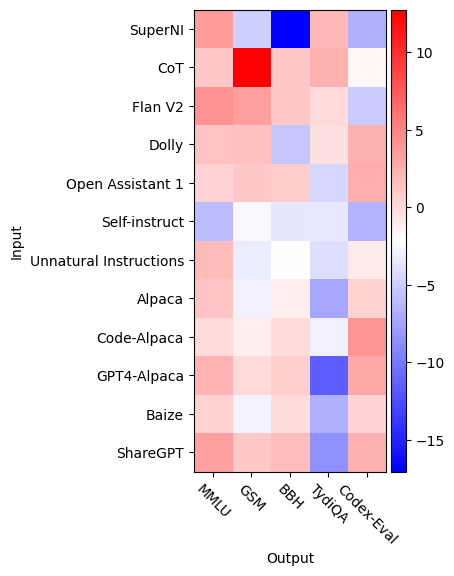

In [142]:
from rosemary import plt_scaled_colobar_ax
# (n_input, n_output)
W = np.stack([regr.estimators_[i].coef_ for i in range(len(regr.estimators_))]).T
b = [regr.estimators_[i].intercept_ for i in range(len(regr.estimators_))]

fig, ax = plt.subplots(1,1,figsize=(3,6))
im = ax.imshow(W, cmap='bwr')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_ylabel('Input')
ax.set_xlabel('Output')
ax.set_yticks(list(range(len(datasets))), datasets)
ax.set_xticks(list(range(len(tasks))), tasks, rotation=-45)


In [119]:
y_pred = regr.predict(X[-2:])
y_pred

array([[  6.8 ,  18.75,  -2.45,  -2.4 ,  -1.85],
       [ 12.45,  18.75,  -0.3 , -25.6 ,   7.55]])

In [80]:
y_test

array([[7.899999999999999, 22.5, 2.5, 2.3999999999999986,
        -2.900000000000002],
       [6.700000000000003, 22.5, 5.899999999999999, -1.2999999999999972,
        8.399999999999999]], dtype=object)

,MMLU,GSM,BBH,TydiQA,Codex-Eval
13,50.4,36.5,39.4,49.8,23.7
14,49.2,36.5,42.8,46.1,35.0
